# Importing an Excel file with an unknown format.

In this notebook, we will use the `ExcelImporter` to get all data from the spreadsheet, but will have to write strategies to understand the data ourselves.

In [1]:
from brightway2 import *
from stats_arrays import *

## Basic setup

Start a new project, and install base data.

In [2]:
projects.current = "excel import"

In [3]:
bw2setup()

Creating default biosphere

Applying strategy: normalize_units

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 0.655 sec



Applying strategy: drop_unspecified_subcategories
Applied 2 strategies in 0.02 seconds
Title: Writing activities to SQLite3 database:
  Started: 11/07/2015 15:49:55
  Finished: 11/07/2015 15:49:56
  Total time elapsed: 0.655 sec
  CPU %: 91.400000
  Memory %: 1.279688
Created database: biosphere3
Creating default LCIA methods

Applying strategy: normalize_units
Applying strategy: set_biosphere_type
Applying strategy: drop_unspecified_subcategories
Applying strategy: link_iterable_by_fields
Applied 4 strategies in 1.78 seconds
Wrote 692 LCIA methods with 170915 characterization factors
Creating core data migrations



## Import Ecoinvent 3.1

The file we want to import has links to ecoinvent 3.1, so we will need to import this database.

In [4]:
ei = SingleOutputEcospold2Importer(
    "/Users/cmutel/Documents/LCA Documents/Ecoinvent/3.1/cutoff/datasets", 
    "ecoinvent 3.1 cutoff"
)
ei.apply_strategies()
ei.write_database()

Extracting ecospold2 files:
0%                          100%
[##############################] | ETA[sec]: 0.000 | Item ID: fff527b1-0fe4-4
Total time elapsed: 118.347 sec


Title: Extracting ecospold2 files:
  Started: 11/07/2015 15:51:39
  Finished: 11/07/2015 15:53:37
  Total time elapsed: 118.347 sec
  CPU %: 90.600000
  Memory %: 12.439108
Extracted 11301 datasets in 119.96 seconds
Applying strategy: normalize_units
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspecified_subcategories
Applying strategy: link_biosphere_by_flow_uuid
Applying strategy: link_internal_technosphere_by_composite_code
Applying strategy: delete_exchanges_missing_activity
Applying strategy: delete_ghost_exchanges
Applied 12 strategies in 3.78 seconds

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 73.147 sec



Title: Writing activities to SQLite3 database:
  Started: 11/07/2015 15:53:41
  Finished: 11/07/2015 15:54:55
  Total time elapsed: 73.147 sec
  CPU %: 84.000000
  Memory %: 13.480759
Created database: ecoinvent 3.1 cutoff


Brightway2 SQLiteBackend: ecoinvent 3.1 cutoff

No need to keep the importer object around.

In [5]:
ei = None

# Get spreadsheet data

Import the example spreadsheet data, and let's see what we have:

In [38]:
ex = ExcelImporter("files/example_excel_file.xlsx", "example")

Extracted 1 worksheets in 0.02 seconds


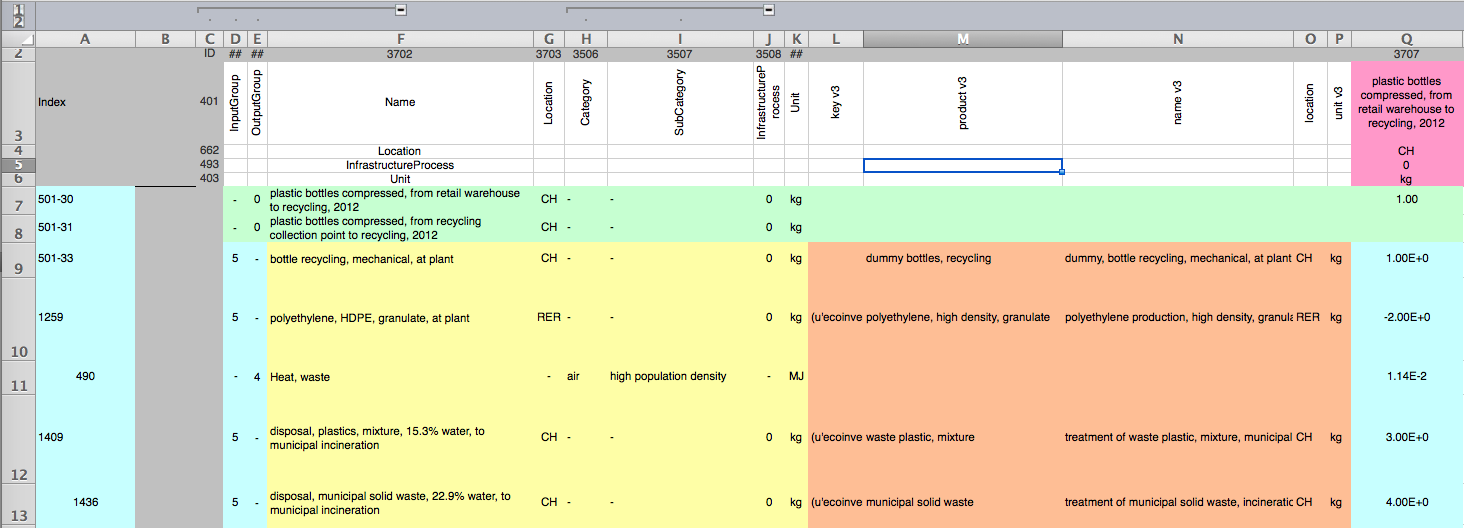

In [52]:
from IPython.display import Image
Image(filename='files/example-excel-file.png') 

## Extracting main data

OK, so we need to:

* Extract the process and its reference product
* Extract process metadata
* Extract exchange values and links

We could do this in a series of small functions chained together, but maybe it is easier to just process everything in one strategy.

A strategy is a function that transforms your data - in our case, from a list of lists of raw data values to something we can interact with.

In [39]:
uncertainty_mapping = {
    0: UndefinedUncertainty.id,
    1: LognormalUncertainty.id,
    2: NormalUncertainty.id,
    3: TriangularUncertainty.id,
    4: UniformUncertainty.id
}

In [40]:
PROCESS_INDEX_NUMBER = 3707
PROCESS_INDEX_COL = 0
PROCESS_INDEX_ROW = 1
PROCESS_NAME_ROW = 2
PROCESS_LOCATION_ROW = 3
PROCESS_UNIT_ROW = 5

INPUT_GROUP_COL = 3
OUTPUT_GROUP_COL = 4
PRODUCTION_EXC_TYPE = 0
TECHNOSPHERE_EXC_TYPE = 5
BIOSPHERE_EXC_TYPE = 4

CATEGORY_COL = 7
SUBCATEGORY_COL = 8 

EXCHANGE_PRODUCTION_NAME_COL = 5
EXCHANGE_PRODUCT_COL = 12
EXCHANGE_PROCESS_COL = 13
EXCHANGE_LOCATION_COL = 14
EXCHANGE_UNIT_COL = 10
EXCHANGE_AMOUNT_DELTA = 0
EXCHANGE_UNCERTAINTY_TYPE_DELTA = 1
EXCHANGE_SD95_DELTA = 2
EXCHANGE_COMMENT_DELTA = 3


def get_exchange_type(data, row):
    if data[row][INPUT_GROUP_COL] == TECHNOSPHERE_EXC_TYPE:
        return "technosphere"
    elif data[row][OUTPUT_GROUP_COL] == BIOSPHERE_EXC_TYPE:
        return "biosphere"
    elif data[row][INPUT_GROUP_COL] == BIOSPHERE_EXC_TYPE:
        return "biosphere"
    elif data[row][OUTPUT_GROUP_COL] == PRODUCTION_EXC_TYPE:
        return "production"
    else:
        raise ValueError
    

def get_exchange_rows(data):
    return [x for x in range(len(data)) 
            if data[x][PROCESS_INDEX_COL] 
            and data[x][PROCESS_INDEX_COL] != "Index"]
    
    
def extract_exchanges(data, col):
    return [{
        'production name': data[row][EXCHANGE_PRODUCTION_NAME_COL],
        'activity name': data[row][EXCHANGE_PROCESS_COL],
        'categories': (data[row][CATEGORY_COL], data[row][SUBCATEGORY_COL],),
        'type': get_exchange_type(data, row),
        'reference product': data[row][EXCHANGE_PRODUCT_COL],
        'unit': data[row][EXCHANGE_UNIT_COL],
        'location': data[row][EXCHANGE_LOCATION_COL],
        'amount': data[row][col + EXCHANGE_AMOUNT_DELTA] or 0,
        'uncertainty type': uncertainty_mapping[data[row][col + EXCHANGE_UNCERTAINTY_TYPE_DELTA] or 0],
        'sd95': data[row][col + EXCHANGE_SD95_DELTA],  # Will need to be transformed
        'comment': data[row][col + EXCHANGE_COMMENT_DELTA]
    } for row in get_exchange_rows(data)]
    

def extract_process(data, col, sheet):
    return {
        'name': data[PROCESS_NAME_ROW][col],
        'unit': data[PROCESS_UNIT_ROW][col],
        'location': data[PROCESS_LOCATION_ROW][col],
        'worksheet': sheet,
        'exchanges': extract_exchanges(data, col)
    }


def process_sample_worksheet(obj):
    ws_name, data = obj

    nrows, ncols = len(data), len(data[0])
    
    # Create dictionary of processes referred to by column index
    processes = [extract_process(data, col, ws_name) 
                 for col in range(ncols) 
                 if data[PROCESS_INDEX_ROW][col] == PROCESS_INDEX_NUMBER]
    
    return processes


def process_sample_excel_data(data):
    return [item for obj in data for item in process_sample_worksheet(obj)]

## Data manipulation strategies

We can now decide if we want the name to refer to `activity name` or `production name`; This is actually pretty easy.

In [41]:
def choose_name(data):
    """Get either activity or production name, and set to `name` field."""
    for ds in data:
        for exc in ds['exchanges']:
            exc['name'] = exc['activity name'] or exc['production name']
            del exc['production name']
            del exc['activity name']
    return data

Delete fields where we don't have data:

In [42]:
def clean_blank_fields(data):
    """Delete all exchange fields whose value is `''`."""
    for ds in data:
        ds['exchanges'] = [{k: v for k, v in exc.items() if v is not ''} 
                           for exc in ds['exchanges']]
    return data

Let's see what our data looks like so far:

In [43]:
clean_blank_fields(choose_name(process_sample_excel_data(ex.data)))

[{'exchanges': [{'amount': 1.0,
    'categories': ('-', '-'),
    'name': 'plastic bottles compressed, from retail warehouse to recycling, 2012',
    'type': 'production',
    'uncertainty type': 0,
    'unit': 'kg'},
   {'amount': 0,
    'categories': ('-', '-'),
    'name': 'plastic bottles compressed, from recycling collection point to recycling, 2012',
    'type': 'production',
    'uncertainty type': 0,
    'unit': 'kg'},
   {'amount': 1.0,
    'categories': ('-', '-'),
    'comment': '(1,1,2,1,1,5); recycling expenses from German recycler (system process);',
    'location': 'CH',
    'name': 'dummy, bottle recycling, mechanical, at plant',
    'reference product': 'dummy bottles, recycling',
    'sd95': 1.2105049293582961,
    'type': 'technosphere',
    'uncertainty type': 2,
    'unit': 'kg'},
   {'amount': -2.0,
    'categories': ('-', '-'),
    'comment': '(1,1,2,1,1,5); Innorecycling only produces HDPE regranulate, which can contain up to 3 % PP (impurity); personal communic

We can drop production exchanges where the amount is one, as this is the default.

In [44]:
def drop_production_exchanges_amount_one(data):
    """Delete categories if not given in Excel file"""
    for ds in data:
        ds['exchanges'] = [exc for exc in ds['exchanges'] 
                           if not (exc['type'] == 'production' and exc['amount'] == 1)]
    return data

We can also delete categories if none are present:

In [45]:
def delete_missing_categories(data):
    """Drop production exchanges where the amount is 1"""
    for ds in data:
        for exc in ds['exchanges']:
            if exc['categories'] in {('', ''), ('-', '-')}:
                del exc['categories']
    return data

## Using existing strategies

Next, we add some already created strategies to:

* Normalize units
* Delete production exchanges with amounts of 0
* Normalize biosphere flow names and categories
* Remove locations from biosphere exchanges

In [46]:
from bw2io.strategies import (
    normalize_units,    
    remove_zero_amount_coproducts,
    normalize_biosphere_categories,
    normalize_biosphere_names,
    strip_biosphere_exc_locations,
)

## Applying strategies and linking databases

Let's add and apply our strategies:

In [47]:
ex.strategies = [
    process_sample_excel_data,
    choose_name,
    clean_blank_fields,
    drop_production_exchanges_amount_one,
    delete_missing_categories,
    normalize_units,    
    remove_zero_amount_coproducts,
    normalize_biosphere_categories,
    normalize_biosphere_names, 
    strip_biosphere_exc_locations,
]

ex.apply_strategies()

Applying strategy: process_sample_excel_data
Applying strategy: choose_name
Applying strategy: clean_blank_fields
Applying strategy: drop_production_exchanges_amount_one
Applying strategy: delete_missing_categories
Applying strategy: normalize_units
Applying strategy: remove_zero_amount_coproducts
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applied 10 strategies in 0.01 seconds


In [48]:
ex.statistics()

2 datasets
18 exchanges
18 unlinked exchanges
  Type biosphere: 1 unique unlinked exchanges
  Type technosphere: 8 unique unlinked exchanges


(2, 18, 18)

In [49]:
ex.match_database("ecoinvent 3.1 cutoff")
ex.statistics()

Applying strategy: link_iterable_by_fields
2 datasets
18 exchanges
8 unlinked exchanges
  Type biosphere: 1 unique unlinked exchanges
  Type technosphere: 3 unique unlinked exchanges


(2, 18, 8)

In [50]:
ex.match_database(config.biosphere, kind="biosphere")
ex.statistics()

Applying strategy: link_iterable_by_fields
2 datasets
18 exchanges
6 unlinked exchanges
  Type technosphere: 3 unique unlinked exchanges


(2, 18, 6)

In [51]:
for exc in ex.unlinked:
    print(exc)

{'unit': 'kilogram', 'uncertainty type': 2, 'sd95': 1.2105049293582961, 'comment': '(1,1,2,1,1,5); recycling expenses from German recycler (system process);', 'reference product': 'dummy bottles, recycling', 'amount': 1.0, 'type': 'technosphere', 'location': 'CH', 'name': 'dummy, bottle recycling, mechanical, at plant'}
{'unit': 'kilogram', 'uncertainty type': 2, 'sd95': 1.2105049293582961, 'comment': '(1,1,2,1,1,5); float-sink sorting by Innorecycling: PET (4%), PP (2%) and GVK fraction (4%) are sorted out and going to incineration (50% cement kiln, 50% municipal incineration plant); personal communication Markus Tonner, represents the fraction received from Coop 2015;', 'reference product': 'dummy waste plastic, mixture ', 'amount': 6.0, 'type': 'technosphere', 'location': 'CH', 'name': 'dummay, plastic mixture, to cement kiln'}
{'unit': 'ton kilometer', 'uncertainty type': 2, 'sd95': 2.0489631280393423, 'comment': '(1,1,2,1,1,5); average transport distance to the recycling plant (In

And this is quite reasonable - the three unlinked inputs are not found in Ecoinvent, and therefore shouldn't be linked.

The next step would be one of manually link these missing exchanges, writing a data migration to change the input values, and then re-linking to ecoinvent, or creating the unlinked inputs as new processes.

Currently, we can write the dataset in its current state with `ex.write_unlinked`; after linking, we would write the database with `ex.write_database`.